In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from transformers import pipeline

In [2]:
import json
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Appliances.jsonl.gz')

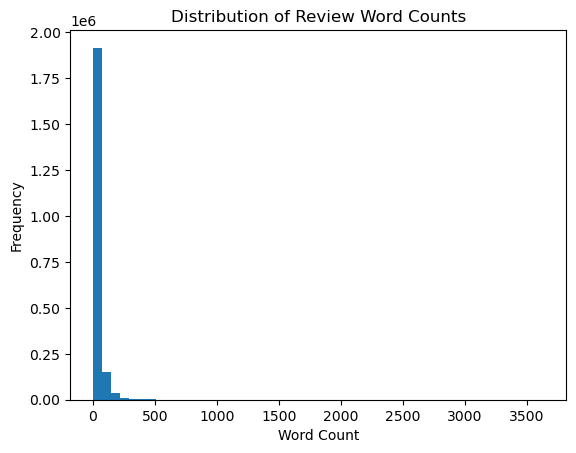

In [3]:
# Function to count words in a review
def count_words(text):
    return len(str(text).split())
# Create a 'count' column for all reviews
df['count'] = df['text'].apply(count_words)

# Plot the distribution of review word counts
plt.hist(df['count'], bins=50)  # You can adjust the number of bins as needed
plt.title("Distribution of Review Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Large Peak at Zero or Small Word Count: The histogram has a large peak at or near the left side, indicating that most of the reviews are relatively short (e.g., under 100 words).
# Small Number of Longer Reviews: Beyond the peak, there are fewer reviews with higher word counts (such as 500 or more words), which is typical for datasets where most reviews are short.

In [4]:
# Get the top 10 longest reviews based on word count
top_10_reviews = df.nlargest(10, 'count')

# Print the top 10 reviews (text and word count)
for index, row in top_10_reviews.iterrows():
    print(f"Review {index}:")
    print(f"Text: {row['text']}")
    print(f"Word Count: {row['count']}")
    print("="*50)  # Separator for readability

Review 1098123:
Text: Powerful and fast is the best way I can describe the cooktop on GE's new Induction Range. It is so incredible it even surpassed all my expectations. It boils water so fast you don't even have time to get the food ready to go in before the lids rattling off the pot. Yet it heats so low that you can melt a large bar of chocolate directly in a pan without having to use a double boiler! It will have it melted and ready to use in 15 minutes, and you can leave it on for hours without worrying about it scorching. Now that's versatility! And the temperature change response time is instant. You can take that pot of boiling water with the lid rattling and reduce the heat to simmer, and the water instantly stops boiling and goes to a gentle simmer in a second. I don't mean in a few seconds. I mean right now! This thing blows gas away so bad it's not even funny. I've used both gas and electric, and gas being the closest contender doesn't even hold a candle to the power and sp

In [5]:
df = df.dropna(subset=['text'])

# Function to count words in a review
def count_words(text):
    return len(str(text).split())

# Filter reviews with more than 100 words
long_reviews = df[df['text'].apply(count_words) > 100].head(10)
long_reviews ['count'] = df['text'].apply(count_words)

In [6]:
summarizer = pipeline("summarization",model="sshleifer/distilbart-cnn-12-6")

Device set to use cpu


In [7]:
print(summarizer.model.config._name_or_path)

sshleifer/distilbart-cnn-12-6


In [8]:
# Apply summarization
long_reviews['summary'] = long_reviews['text'].apply(lambda x: summarizer(x, max_length=80, min_length=50, do_sample=False)[0]['summary_text'])

# Display the first two summaries for your report
report_summaries = long_reviews[['text', 'summary']].head(2).reset_index()


In [9]:
report_summaries=report_summaries.reset_index(drop=True)


In [10]:
report_summaries['summary_count'] = report_summaries['summary'].apply(count_words)
report_summaries

,index,text,summary,summary_count
0,13,im excited to see how the coffee comes out i ...,i got 2 mason jars too so i ordered a 2nd on...,66
1,18,The filter did not fit in my Keurig K50. When ...,The filter did not fit in my Keurig K50 . Aft...,52


In [11]:
print("Original Review no.1")
print(report_summaries['text'][0])


print("Summary Review no.1")
print(report_summaries['summary'][0])


print('\n')
print('===========')
print("\n")


print("Original Review no.1")
print(report_summaries['text'][1])


print("Summary Review no.1")
print(report_summaries['summary'][1])

Original Review no.1
im excited to see how the coffee comes out  i got 2 mason jars too  so i ordered a 2nd one of these so i'll always have 2 in the fridge  for the summer<br /><br />UPDATE:  my first cup was a bit strong  i added way too much coffee i guess but i watered it down with plenty of ice and  half and half - a little cinnamon and vanilla -  i ordered the 2nd filter and it will be here soon and i plan to have iced coffee all summer ...  definitely cutting down on the amount of coffee though !!!!!
Summary Review no.1
 i got 2 mason jars too  so i ordered a 2nd one of these so i'll always have 2 in the fridge . i added way too much coffee i guess but i watered it down with plenty of ice and  half and half . i ordered the 2nd filter and it will be here soon and i plan to have iced coffee all summer .




Original Review no.1
The filter did not fit in my Keurig K50. When closing the keurig, there was still a small gap that left the keurig slightly open. I had to hold down the ke

In [17]:
text = report_summaries['text'][0]
text

"im excited to see how the coffee comes out  i got 2 mason jars too  so i ordered a 2nd one of these so i'll always have 2 in the fridge  for the summer<br /><br />UPDATE:  my first cup was a bit strong  i added way too much coffee i guess but i watered it down with plenty of ice and  half and half - a little cinnamon and vanilla -  i ordered the 2nd filter and it will be here soon and i plan to have iced coffee all summer ...  definitely cutting down on the amount of coffee though !!!!!"

In [16]:
reader = pipeline("question-answering",model="distilbert/distilbert-base-cased-distilled-squad")
question = "How many mason jars are there?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])

Device set to use cpu


,score,start,end,answer
0,0.778445,50,51,2


In [15]:
from evaluate import load

# --- Summarization metrics (BERTScore) ---
reference_summaries = [
    "Excited to make iced coffee, bought two mason jars—ordering a second to always have a pair in the fridge for summer. After an initial overly strong brew, they diluted it with ice, half‑and‑half, cinnamon, and vanilla. They ordered a replacement filter and plan to definitely enjoy iced coffee all season.",
    "The reusable filter failed to seal in a Keurig K50, forcing the user to hold the machine shut during brewing. Water trickled slowly despite adjusting grind size, yielding less than half a cup. Frustrated by the hassle, they found returns easy with a free label and sent the filter back."
]
generated_summaries = report['summary'].tolist()

bertscore = load("bertscore")
bertscore_res = bertscore.compute(
    predictions=generated_summaries,
    references=reference_summaries,
    lang="en"
)
print("\n===== Summarization Quality (BERTScore) =====")
print(f"Precision: {bertscore_res['precision'][0]:.4f}")
print(f"Recall:    {bertscore_res['recall'][0]:.4f}")
print(f"F1:        {bertscore_res['f1'][0]:.4f}")

# --- QA metrics (Exact Match & F1) ---
# TODO: replace with your real ground-truth answers for each QA example
qa_ground_truths = ["2"]  # for the above question on review #1
predictions = [{"id": str(i), "prediction_text": qa_output['answer']} for i in range(len(qa_ground_truths))]
references  = [{"id": str(i), "answers": {"text":[qa_ground_truths[i]], "answer_start":[0]}} 
               for i in range(len(qa_ground_truths))]

squad = load("squad")
qa_metrics = squad.compute(predictions=predictions, references=references)
print("\n===== QA Accuracy =====")
print(f"Exact Match: {qa_metrics['exact_match']:.2f}")
print(f"F1 Score:    {qa_metrics['f1']:.2f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



===== Summarization Quality (BERTScore) =====
Precision: 0.8768
Recall:    0.8975
F1:        0.8871

===== QA Accuracy =====
Exact Match: 100.00
F1 Score:    100.00
